In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from PIL import Image

def gauss2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    '''
    amplitude: of the 2D gaussian
    x0: center of 2D gaussian
    sigma_x: standard deviation along the x axis
    theta: rotation of the x axis (e.g. fitting a rotated elliptical beam)
    offset: constant offset value of intensity
    '''
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


def fitgauss2d(file, save='', zoom=True):
    img = Image.open(file)
    img = np.array(img)
    
    shape = np.shape(img)
    
    x = np.arange(shape[1])
    y = np.arange(shape[0])
    x, y = np.meshgrid(x, y)

    # [amplitude, x0, y0, sigma_x, sigma_y, theta, offset]
    guess = [np.max(img)]
    norm = np.sum(img)
    guess.append(np.sum(img*x)/norm)
    guess.append(np.sum(img*y)/norm)
    guess.append(np.sqrt(np.sum((x-guess[1])**2*img/norm)))
    guess.append(np.sqrt(np.sum((y-guess[2])**2*img/norm)))
    guess.extend([0,0])
    print(f'Guess: {guess}')

    popt, pcov = curve_fit(gauss2d, (x, y), img.ravel(), p0=guess)
    print(f'Fit: {popt}')
    print()
    print(f'x0      : {int(popt[1])} px')
    print(f'y0      : {int(popt[2])} px')
    print()
    popt[3:5] = np.abs(popt[3:5])
    print(f'SD x    : {popt[3]:.3f} px')
    print(f'SD y    : {popt[4]:.3f} px')
    print(f'ratio   : {np.max(popt[3:5])/np.min(popt[3:5]):.3f}')
    print()
    print(f'FWHM x  : {popt[3]*2.35482:.3f} px')
    print(f'FWHM y  : {popt[4]*2.35482:.3f} px')
    print()
    print(f'1/e^2 x : {popt[3]*2.35482*1.699:.3f} px')
    print(f'1/e^2 y : {popt[4]*2.35482*1.699:.3f} px')
    print()
    print(f'theta   : {np.degrees(popt[5]):.2f} deg')

    fig, ax = plt.subplots()
    
    img = ax.imshow(img, cmap=plt.cm.jet)
    ax.set_aspect('equal')
    # plt.colorbar(img)
    
    ax.contour(x, y, gauss2d((x,y),*popt).reshape(shape), 8, colors='w', alpha=0.3)
    
    # zoom to within 4 sigma
    if zoom:
        sigmas = 4
        ax.set_xlim(max(popt[1]-sigmas*popt[3],0), min(popt[1]+sigmas*popt[3],shape[1]))
        ax.set_ylim(max(popt[2]-sigmas*popt[4],0), min(popt[2]+sigmas*popt[4],shape[0]))
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(file)
    
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')
    
    plt.show()
    return (x,y), img, popt

Guess: [255, 992.4664517660756, 549.7999639109883, 517.917853703547, 289.5819325606937, 0, 0]
Fit: [ 2.15767590e+02  1.17642871e+03  6.06123582e+02 -1.05219593e+02
 -5.64995637e+01 -3.81260296e-03  2.26840320e+01]

x0      : 1176 px
y0      : 606 px

SD x    : 105.220 px
SD y    : 56.500 px
ratio   : 1.862

FWHM x  : 247.773 px
FWHM y  : 133.046 px

1/e^2 x : 420.967 px
1/e^2 y : 226.046 px

theta   : -0.22 deg


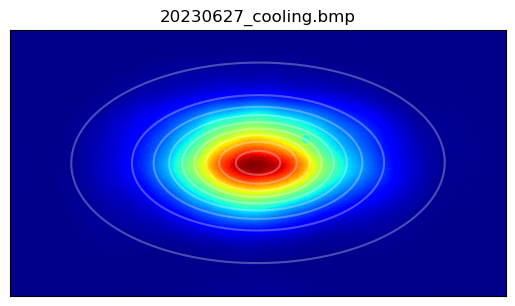

In [2]:
a = fitgauss2d('20230627_cooling.bmp')